# ❄️ I-70 Ski Traffic Analysis ⛷


## The goal of this project is to understand how powder days, holidays, and day of the week patterns affect traffic on Colorado’s I-70 corridor between Denver and the Mountains.

### Specifically, I want to answer:

1. Do powder days (≥ 4 inches of snow) create meaningful increases in traffic?
2. What hours have the heaviest traffic toward the mountains vs. back to Denver?
3. What is the best predictor of congestion during ski season?

*Package Imports*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import glob
import sys
from sklearn.linear_model import LinearRegression

### Data Sources
* Colorado Department of transportation (CDOT) hourly traffic counts (2014—2024) through the Eisenhower Tunnel (11,158 ft) which is the main corridor to get to and from the ski areas
  * "P" direction → Eastbound travel on I-70 to Denver
  * "S" direction → Westbound travel on I-70 to the Mountain Corridor
* Snow Telemetry (SNOTEL) daily snow reports (2014—2024) at Loveland Basin which is at the same elevation and location of the Eisenhower Tunnel

In [2]:
#CDOT Hour Traffic Data @ Eisenhower Tunnel
traffic_files = sorted(
    glob.glob("20*.csv"),
    key=lambda x: int(x.split('.')[0])
)

traffic = pd.concat([pd.read_csv(f) for f in traffic_files], ignore_index=True)

traffic['date'] = pd.to_datetime(traffic['COUNTDATE'], format='%Y%m%d')
traffic = traffic.sort_values('date').reset_index(drop=True)

traffic.head()

,COUNTSTATIONID,COUNTDATE,COUNTDIR,HOUR0,HOUR1,HOUR2,HOUR3,HOUR4,HOUR5,HOUR6,...,HOUR16,HOUR17,HOUR18,HOUR19,HOUR20,HOUR21,HOUR22,HOUR23,FormattedDate,date
0,106,20140101,P,65,68,47,46,86,144,235,...,965,1112,1301,1433,1774,1353,370,163,01/01/2014,2014-01-01
1,106,20140101,S,65,84,85,62,59,74,277,...,822,1079,659,429,388,260,234,173,01/01/2014,2014-01-01
2,106,20140102,P,115,80,87,89,167,373,733,...,1918,1881,1162,768,513,351,209,165,01/02/2014,2014-01-02
3,106,20140102,S,135,98,72,69,119,148,437,...,1096,883,655,596,477,389,300,240,01/02/2014,2014-01-02
4,106,20140103,P,76,58,76,74,126,215,465,...,1574,2106,1823,1018,709,427,262,198,01/03/2014,2014-01-03


In [3]:
#List of all hour columns
hours = [c for c in traffic.columns if c.startswith("HOUR")]

#Daily Total
traffic["DAILY TOTAL"] = traffic[hours].sum(axis=1)

#Day of the Week
traffic["DAY OF THE WEEK"] = traffic["date"].dt.day_name()

#Drop Extra Columns
traffic = traffic.drop(columns=["COUNTSTATIONID", "FormattedDate"], errors="ignore")

#Rename Columns
traffic = traffic.rename(columns={"date": "DATE"})

In [4]:
#To the Mountains–Secondary direction
mountain_traffic = traffic[traffic["COUNTDIR"] == "S"].copy()

#Return to Denver–Primary direction
denver_traffic = traffic[traffic["COUNTDIR"] == "P"].copy()

In [5]:
mountain_traffic.head()

,COUNTDATE,COUNTDIR,HOUR0,HOUR1,HOUR2,HOUR3,HOUR4,HOUR5,HOUR6,HOUR7,...,HOUR17,HOUR18,HOUR19,HOUR20,HOUR21,HOUR22,HOUR23,DATE,DAILY TOTAL,DAY OF THE WEEK
1,20140101,S,65,84,85,62,59,74,277,776,...,1079,659,429,388,260,234,173,2014-01-01,16105,Wednesday
3,20140102,S,135,98,72,69,119,148,437,1352,...,883,655,596,477,389,300,240,2014-01-02,19156,Thursday
5,20140103,S,120,106,77,70,126,185,425,1473,...,1654,1542,1562,1222,793,500,299,2014-01-03,24355,Friday
7,20140104,S,181,111,88,59,74,131,405,971,...,717,531,465,375,235,229,148,2014-01-04,14298,Saturday
9,20140105,S,99,81,66,48,56,55,408,1541,...,661,531,370,299,234,193,137,2014-01-05,14264,Sunday


In [6]:
denver_traffic.head()

,COUNTDATE,COUNTDIR,HOUR0,HOUR1,HOUR2,HOUR3,HOUR4,HOUR5,HOUR6,HOUR7,...,HOUR17,HOUR18,HOUR19,HOUR20,HOUR21,HOUR22,HOUR23,DATE,DAILY TOTAL,DAY OF THE WEEK
0,20140101,P,65,68,47,46,86,144,235,428,...,1112,1301,1433,1774,1353,370,163,2014-01-01,19655,Wednesday
2,20140102,P,115,80,87,89,167,373,733,1005,...,1881,1162,768,513,351,209,165,2014-01-02,22520,Thursday
4,20140103,P,76,58,76,74,126,215,465,689,...,2106,1823,1018,709,427,262,198,2014-01-03,23356,Friday
6,20140104,P,104,66,81,83,93,174,370,540,...,1150,860,700,512,303,148,106,2014-01-04,17063,Saturday
8,20140105,P,61,55,70,66,112,189,370,599,...,1279,1434,1427,1089,478,236,120,2014-01-05,22681,Sunday


In [7]:
#SNOTEL Data @ Loveland Basin

snow_totals = pd.read_csv("snowtotalsloveland.csv")
snow_totals.head()

,Date,Snow Water Equivalent (in) Start of Day Values,Change In Snow Water Equivalent (in),Snow Depth (in) Start of Day Values,Change In Snow Depth (in),Air Temperature Average (degF),Air Temperature Maximum (degF),Air Temperature Minimum (degF)
0,2014-01-01,7.8,0.0,35,0,10.6,17.8,4.3
1,2014-01-02,8.2,0.4,40,5,15.6,23.5,6.3
2,2014-01-03,8.2,0.0,38,-2,20.8,27.1,13.3
3,2014-01-04,8.3,0.1,37,-1,5.2,19.6,-6.2
4,2014-01-05,8.7,0.4,41,4,-7.4,-4.2,-9.2


In [8]:
#Retitle Columns
snow_totals = snow_totals.rename(columns={"Date": "DATE"})
snow_totals["DATE"] = pd.to_datetime(snow_totals["DATE"])

#Compute New Snowfall based on Avg. Temperature
def snow_ratio(temp_f):
    if pd.isna(temp_f):
        return 12 
    if temp_f <= 10:
        return 22
    if temp_f <= 20:
        return 17
    if temp_f <= 26:
        return 13
    if temp_f <= 31:
        return 9
    return 5
snow_totals["Snow Ratio"] = snow_totals["Air Temperature Average (degF)"].apply(snow_ratio)

snow_totals["Temp Adjusted Snowfall"] = (
    snow_totals["Change In Snow Water Equivalent (in)"] * snow_totals["Snow Ratio"]
)

#Drop Extra Columns
snow_totals = snow_totals.drop(columns=["Snow Water Equivalent (in) Start of Day Values", "Snow Depth (in) Start of Day Values", "Change In Snow Depth (in)"], errors="ignore")

snow_totals.head()

,DATE,Change In Snow Water Equivalent (in),Air Temperature Average (degF),Air Temperature Maximum (degF),Air Temperature Minimum (degF),Snow Ratio,Temp Adjusted Snowfall
0,2014-01-01,0.0,10.6,17.8,4.3,17,0.0
1,2014-01-02,0.4,15.6,23.5,6.3,17,6.8
2,2014-01-03,0.0,20.8,27.1,13.3,13,0.0
3,2014-01-04,0.1,5.2,19.6,-6.2,22,2.2
4,2014-01-05,0.4,-7.4,-4.2,-9.2,22,8.8


In [9]:
#Combine Data

traffic_mountain = pd.merge(
    mountain_traffic,
    snow_totals,
    on="DATE",
    how="inner"
)

traffic_denver = pd.merge(
    denver_traffic,
    snow_totals,
    on="DATE",
    how="inner"
)

#Clean combined data to only look at the prime skiing months
ski_months = [11, 12, 1, 2, 3, 4]

ski_mountain = traffic_mountain[traffic_mountain['DATE'].dt.month.isin(ski_months)].copy()
ski_denver = traffic_denver[traffic_denver['DATE'].dt.month.isin(ski_months)].copy()


In [10]:
ski_mountain.head()

,COUNTDATE,COUNTDIR,HOUR0,HOUR1,HOUR2,HOUR3,HOUR4,HOUR5,HOUR6,HOUR7,...,HOUR23,DATE,DAILY TOTAL,DAY OF THE WEEK,Change In Snow Water Equivalent (in),Air Temperature Average (degF),Air Temperature Maximum (degF),Air Temperature Minimum (degF),Snow Ratio,Temp Adjusted Snowfall
0,20140101,S,65,84,85,62,59,74,277,776,...,173,2014-01-01,16105,Wednesday,0.0,10.6,17.8,4.3,17,0.0
1,20140102,S,135,98,72,69,119,148,437,1352,...,240,2014-01-02,19156,Thursday,0.4,15.6,23.5,6.3,17,6.8
2,20140103,S,120,106,77,70,126,185,425,1473,...,299,2014-01-03,24355,Friday,0.0,20.8,27.1,13.3,13,0.0
3,20140104,S,181,111,88,59,74,131,405,971,...,148,2014-01-04,14298,Saturday,0.1,5.2,19.6,-6.2,22,2.2
4,20140105,S,99,81,66,48,56,55,408,1541,...,137,2014-01-05,14264,Sunday,0.4,-7.4,-4.2,-9.2,22,8.8


## 📊 Ski_Mountain

### Columns:
* Daily Date → Numerical Date
* COUNTDIR → "S"econdary direction of traffic heading westbound on I-70
* Hour0...Hour23 → Hourly counts of cars that passed through the Eisenhower Tunnel
* Daily Total → Computed total of Hour0...Hour23
* Day of the Week → Computed day of the week
* Change in Snow Water Equivalent ("SWE") → Change in SWE (the amount of water that would be remain if snow melted) over last 24 hours
* Snow Ratio → Computed ratio of snowfall equivalent depending on temperature (the colder the temp the more inches of snow that fall)
* Temp Adj. Snowfall → Computed new snowfall over the last 24 hours by taking the avg. temp and x by the snow ratio

### Rows:
* Line item for Daily Date → (1/1/2024 - 12/31/2024) filterd to ski season only (Jan, Feb, Mar, Apr, Nov, Dec)

In [11]:
ski_denver.head()

,COUNTDATE,COUNTDIR,HOUR0,HOUR1,HOUR2,HOUR3,HOUR4,HOUR5,HOUR6,HOUR7,...,HOUR23,DATE,DAILY TOTAL,DAY OF THE WEEK,Change In Snow Water Equivalent (in),Air Temperature Average (degF),Air Temperature Maximum (degF),Air Temperature Minimum (degF),Snow Ratio,Temp Adjusted Snowfall
0,20140101,P,65,68,47,46,86,144,235,428,...,163,2014-01-01,19655,Wednesday,0.0,10.6,17.8,4.3,17,0.0
1,20140102,P,115,80,87,89,167,373,733,1005,...,165,2014-01-02,22520,Thursday,0.4,15.6,23.5,6.3,17,6.8
2,20140103,P,76,58,76,74,126,215,465,689,...,198,2014-01-03,23356,Friday,0.0,20.8,27.1,13.3,13,0.0
3,20140104,P,104,66,81,83,93,174,370,540,...,106,2014-01-04,17063,Saturday,0.1,5.2,19.6,-6.2,22,2.2
4,20140105,P,61,55,70,66,112,189,370,599,...,120,2014-01-05,22681,Sunday,0.4,-7.4,-4.2,-9.2,22,8.8


## 📊 Ski_Denver

### Columns:
* Daily Date → Numerical Date
* COUNTDIR → "P"rimary direction of traffic heading eastbound on I-70
* Hour0...Hour23 → Hourly counts of cars that passed through the Eisenhower Tunnel
* Daily Total → Computed total of Hour0...Hour23
* Day of the Week → Computed day of the week
* Change in Snow Water Equivalent ("SWE") → Change in SWE (the amount of water that would be remain if snow melted) over last 24 hours
* Snow Ratio → Computed ratio of snowfall equivalent depending on temperature (the colder the temp the more inches of snow that fall)
* Temp Adj. Snowfall → Computed new snowfall over the last 24 hours by taking the avg. temp and x by the snow ratio

### Rows:
* Line item for Daily Date → (1/1/2024 - 12/31/2024) filterd to ski season only (Jan, Feb, Mar, Apr, Nov, Dec)


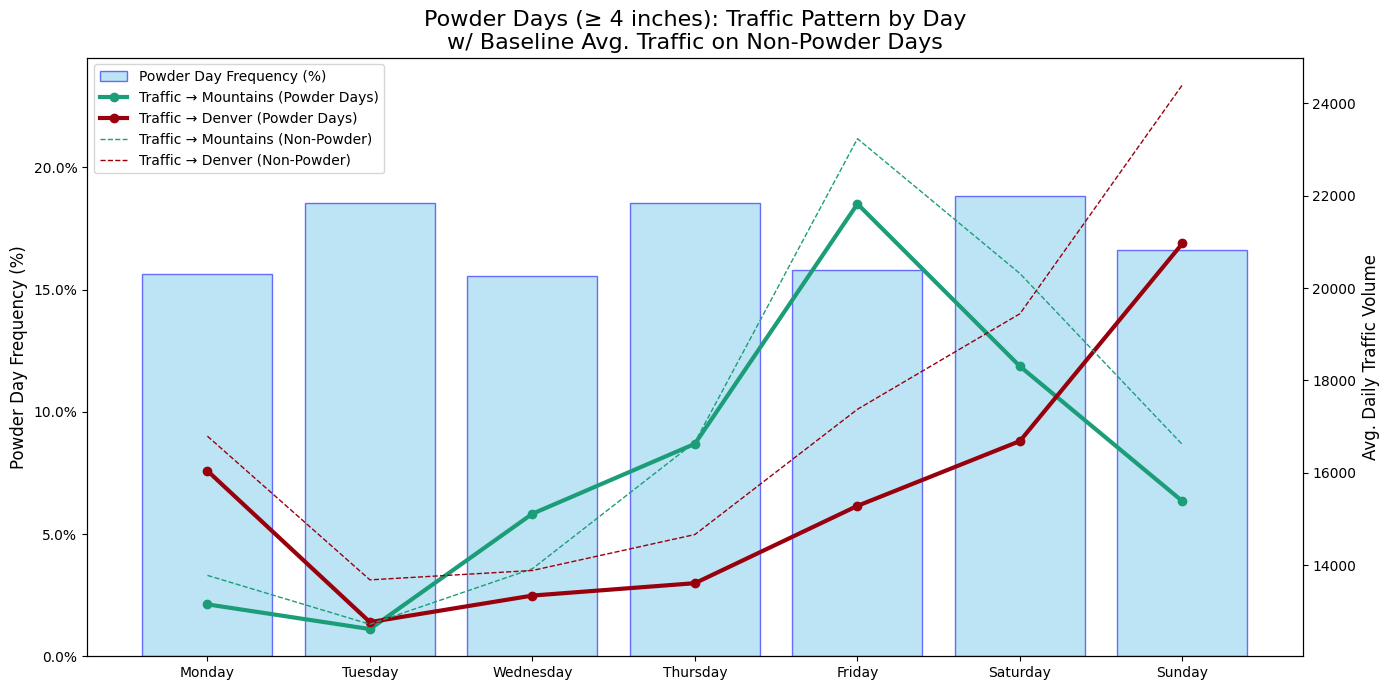

In [12]:
weekday_order = ['Monday', 'Tuesday', 'Wednesday',
                 'Thursday', 'Friday', 'Saturday', 'Sunday']

#Power Day is More than 4 inches of Snow
powder_days = snow_totals[snow_totals['Temp Adjusted Snowfall'] >= 4].copy()
powder_days["DAY OF THE WEEK"] = powder_days["DATE"].dt.day_name()

powder_dates = set(powder_days['DATE'])

#Frequency of Powder Days
powder_counts = (
    powder_days.groupby("DAY OF THE WEEK").size().reindex(weekday_order)
)

total_counts = (
    ski_mountain.groupby("DAY OF THE WEEK").size().reindex(weekday_order)
)

powder_frequency = (powder_counts / total_counts * 100).round(2)


#Powder Day Traffic
powder_mtn_avg = (
    ski_mountain[ski_mountain['DATE'].isin(powder_dates)]
    .groupby("DAY OF THE WEEK")["DAILY TOTAL"]
    .mean()
    .reindex(weekday_order)
)

powder_den_avg = (
    traffic_denver[traffic_denver['DATE'].isin(powder_dates)]
    .groupby("DAY OF THE WEEK")["DAILY TOTAL"]
    .mean()
    .reindex(weekday_order)
)


#Non-Powder Day Traffic
nonpowder_mtn = ski_mountain[~ski_mountain['DATE'].isin(powder_dates)]
nonpowder_den = traffic_denver[~traffic_denver['DATE'].isin(powder_dates)]

nonpowder_mtn_avg = (
    nonpowder_mtn.groupby("DAY OF THE WEEK")["DAILY TOTAL"]
    .mean()
    .reindex(weekday_order)
)

nonpowder_den_avg = (
    nonpowder_den.groupby("DAY OF THE WEEK")["DAILY TOTAL"]
    .mean()
    .reindex(weekday_order)
)


fig, ax1 = plt.subplots(figsize=(14,7))

#Powder Frequency Chart
ax1.bar(
    weekday_order,
    powder_frequency,
    color="skyblue",
    edgecolor="blue",
    alpha=0.55,
    label="Powder Day Frequency (%)"
)

ax1.set_ylabel("Powder Day Frequency (%)", fontsize=12)
ax1.set_ylim(0, powder_frequency.max() * 1.3)
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())


ax2 = ax1.twinx()

#Powder Day Lines
ax2.plot(weekday_order, powder_mtn_avg, marker='o', color="#1b9e77", linewidth=3,
         label="Traffic → Mountains (Powder Days)")
ax2.plot(weekday_order, powder_den_avg, marker='o', color="#99000d", linewidth=3,
         label="Traffic → Denver (Powder Days)")

#Baseline Non-Powder Days
ax2.plot(weekday_order, nonpowder_mtn_avg, linestyle='--', color="#1b9e77",
         linewidth=1, label="Traffic → Mountains (Non-Powder)")
ax2.plot(weekday_order, nonpowder_den_avg, linestyle='--',
         color="#99000d", linewidth=1,
         label="Traffic → Denver (Non-Powder)")

ax2.set_ylabel("Avg. Daily Traffic Volume", fontsize=12)

plt.title("Powder Days (≥ 4 inches): Traffic Pattern by Day\n"
          "w/ Baseline Avg. Traffic on Non-Powder Days", fontsize=16)

#Legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 1️⃣ Do powder days (≥ 4 inches of snow) create meaningful increases in traffic?

Powder days do NOT show any meaningful increases in traffic—in fact, there is slightly less traffic on powder days. This may be because less people travel when it's snowy (not everyone chases powder!), we have traction laws in CO, and Loveland Passs actually closes if it snows enough and travel is dangerous given its elevation of 11,158 ft. 


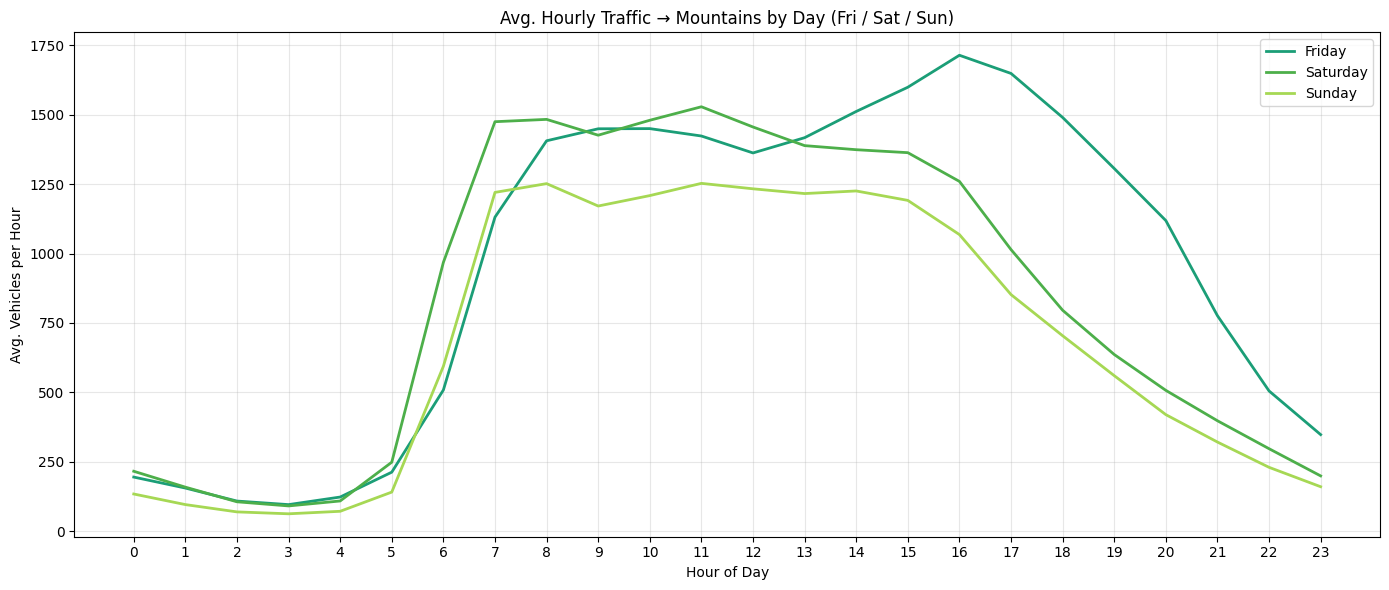

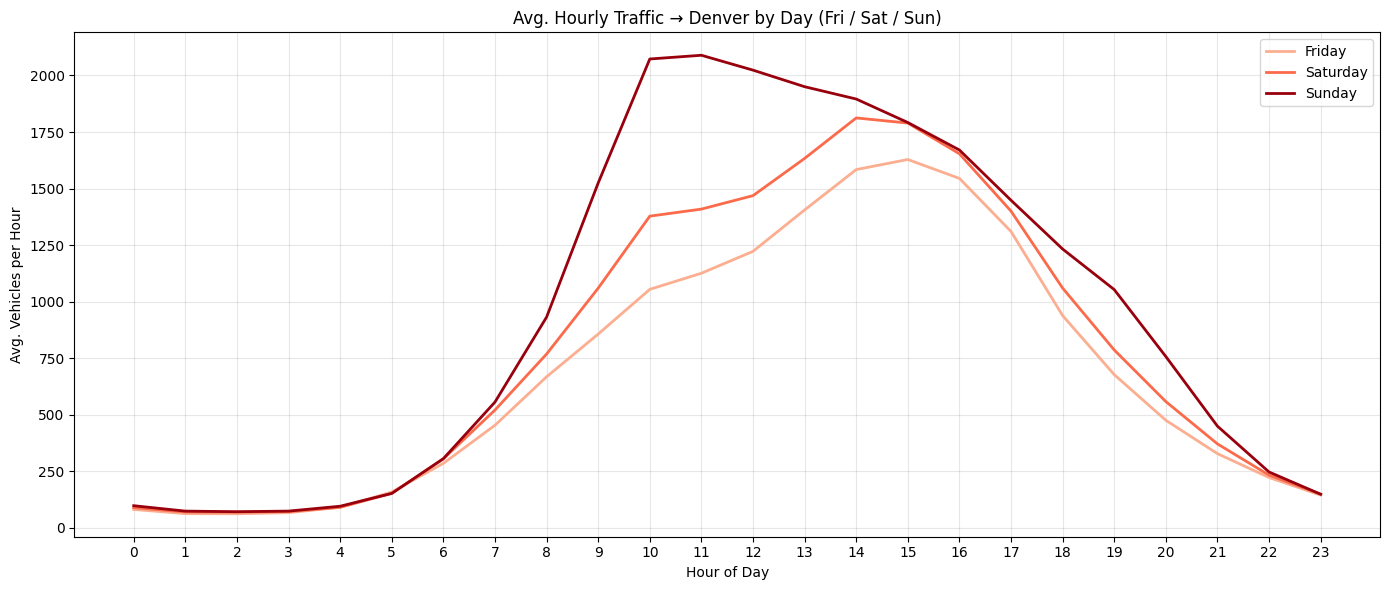

In [15]:
hour_cols = [f"HOUR{i}" for i in range(24)]
hours = list(range(24))

#Traffic Patterns
weekend_days = ["Friday", "Saturday", "Sunday"]

mtn_profiles = {}
for day in weekend_days:
    mask = ski_mountain["DAY OF THE WEEK"] == day
    mtn_profiles[day] = ski_mountain.loc[mask, hour_cols].mean()

den_profiles = {}
for day in weekend_days:
    mask = ski_denver["DAY OF THE WEEK"] == day
    den_profiles[day] = ski_denver.loc[mask, hour_cols].mean()

plt.figure(figsize=(14,6))

plt.plot(hours, mtn_profiles["Friday"], label="Friday",   color="#1b9e77", linestyle="-",  linewidth=2)
plt.plot(hours, mtn_profiles["Saturday"], label="Saturday", color="#4daf4a", linestyle="-", linewidth=2)
plt.plot(hours, mtn_profiles["Sunday"], label="Sunday",   color="#a6d854", linestyle="-",  linewidth=2)

plt.title("Avg. Hourly Traffic → Mountains by Day (Fri / Sat / Sun)")
plt.xlabel("Hour of Day")
plt.ylabel("Avg. Vehicles per Hour")
plt.xticks(hours)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,6))

plt.plot(hours, den_profiles["Friday"], label="Friday",   color="#fcae91", linestyle="-",  linewidth=2)
plt.plot(hours, den_profiles["Saturday"], label="Saturday", color="#fb6a4a", linestyle="-", linewidth=2)
plt.plot(hours, den_profiles["Sunday"], label="Sunday",   color="#99000d", linestyle="-",  linewidth=2)

plt.title("Avg. Hourly Traffic → Denver by Day (Fri / Sat / Sun)")
plt.xlabel("Hour of Day")
plt.ylabel("Avg. Vehicles per Hour")
plt.xticks(hours)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## 2️⃣ What hours have the heaviest traffic toward the mountains vs. back to Denver?
* Mountain traffic peaks on Friday's after work (4PM) indicating people leave later in the day than on Saturday and Sunday where the peak is steady throughout normal ski hours (7AM - 4PM)
* Denver return traffic peaks on Sundays between 10-11AM indicating people like to get an early start heading back vs. Friday and Saturday where traffic peaks at the end of the ski day (2-4PM)

In [14]:
#Regression Models
df = ski_mountain.copy()

##Head to the Mountains
#Powder Day
df["Powder Day"] = (df["Temp Adjusted Snowfall"] >= 4).astype(int)

#Holiday Weekend

def make_holiday_weekend_flags(df):
    df = df.copy()
    df["Holiday Weekend"] = 0
    
    years = df["DATE"].dt.year.unique()
    
    for y in years:
        #MLK Monday
        mlk = pd.date_range(f"{y}-01-01", f"{y}-01-31")
        mlk_monday = mlk[mlk.day_name() == "Monday"][2] 
        mlk_weekend = pd.date_range(mlk_monday - pd.Timedelta(days=2),
                                    mlk_monday)
        
        #Presidents Day
        feb = pd.date_range(f"{y}-02-01", f"{y}-02-28")
        pres_monday = feb[feb.day_name() == "Monday"][2]
        pres_weekend = pd.date_range(pres_monday - pd.Timedelta(days=2),
                                     pres_monday)
        
        #Thanksgiving
        nov = pd.date_range(f"{y}-11-01", f"{y}-11-30")
        thursdays = nov[nov.day_name() == "Thursday"]
        thanks = thursdays[3]
        thanks_weekend = pd.date_range(thanks,
                                       thanks + pd.Timedelta(days=3))
        
        #Christmas / NYE
        xmas_period = pd.date_range(f"{y}-12-23", f"{y+1}-01-02")
        
        #Flag all holiday ranges
        for rng in [mlk_weekend, pres_weekend, thanks_weekend]:
            df.loc[df["DATE"].isin(rng), "Holiday Weekend"] = 1
        
        #Christmas / NYE (don't double-label)
        df.loc[df["DATE"].isin(xmas_period), "Holiday Weekend"] = 1

    return df

df = make_holiday_weekend_flags(df)

#Day of the Week Dummies
df["Day"] = df["DATE"].dt.day_name()
df = pd.get_dummies(df, columns=["Day"], drop_first=False)

#Make Baseline the Avg. Daily Traffic
baseline = df["DAILY TOTAL"].mean()
df["traffic_vs_avg"] = df["DAILY TOTAL"] - baseline

#Predictors
predictors = [
    "Powder Day",
    "Holiday Weekend",
] + [col for col in df.columns if col.startswith("Day")]

X = df[predictors]
y = df["traffic_vs_avg"]

#Model
model = LinearRegression()
model.fit(X, y)

#Results
print("Regression Results: Traffic to the Mountains \n")
print(f"Baseline traffic: {baseline:,.0f}\n")
print("Results:")
for name, coef in zip(predictors, model.coef_):
    print(f"{name:25s}: {coef:,.2f}")


##Return to Denver
df = ski_denver.copy()

#Powder Day
df["Powder Day"] = (df["Temp Adjusted Snowfall"] >= 4).astype(int)

#Holiday Weekend

def make_holiday_weekend_flags(df):
    df = df.copy()
    df["Holiday Weekend"] = 0
    
    years = df["DATE"].dt.year.unique()
    
    for y in years:
        #MLK
        mlk = pd.date_range(f"{y}-01-01", f"{y}-01-31")
        mlk_monday = mlk[mlk.day_name() == "Monday"][2] 
        mlk_weekend = pd.date_range(mlk_monday - pd.Timedelta(days=2),
                                    mlk_monday)
        
        #Presidents Day
        feb = pd.date_range(f"{y}-02-01", f"{y}-02-28")
        pres_monday = feb[feb.day_name() == "Monday"][2]
        pres_weekend = pd.date_range(pres_monday - pd.Timedelta(days=2),
                                     pres_monday)
        
        #Thanksgiving
        nov = pd.date_range(f"{y}-11-01", f"{y}-11-30")
        thursdays = nov[nov.day_name() == "Thursday"]
        thanks = thursdays[3]
        thanks_weekend = pd.date_range(thanks,
                                       thanks + pd.Timedelta(days=3))
        
        #Christmas / NYE
        xmas_period = pd.date_range(f"{y}-12-23", f"{y+1}-01-02")
        
        #Flag all holiday ranges
        for rng in [mlk_weekend, pres_weekend, thanks_weekend]:
            df.loc[df["DATE"].isin(rng), "Holiday Weekend"] = 1
        
        #Christmas / NYE (don't double-label)
        df.loc[df["DATE"].isin(xmas_period), "Holiday Weekend"] = 1

    return df

df = make_holiday_weekend_flags(df)

#Day of the Week Dummies
df["Day"] = df["DATE"].dt.day_name()
df = pd.get_dummies(df, columns=["Day"], drop_first=False)

#Make Baseline the Avg. Daily Traffic
baseline = df["DAILY TOTAL"].mean()
df["traffic_vs_avg"] = df["DAILY TOTAL"] - baseline

#Predictors
predictors = [
    "Powder Day",
    "Holiday Weekend",
] + [col for col in df.columns if col.startswith("Day")]

X = df[predictors]
y = df["traffic_vs_avg"]

#Model
model = LinearRegression()
model.fit(X, y)

#Results
print("\nRegression Results: Traffic back to Denver \n")
print(f"Baseline traffic: {baseline:,.0f}\n")
print("Results:")
for name, coef in zip(predictors, model.coef_):
    print(f"{name:25s}: {coef:,.2f}")

Regression Results: Traffic to the Mountains 

Baseline traffic: 16,712

Results:
Powder Day               : -725.06
Holiday Weekend          : 2,260.67
Day_Friday               : 6,425.78
Day_Monday               : -3,034.50
Day_Saturday             : 3,192.67
Day_Sunday               : -361.66
Day_Thursday             : 66.68
Day_Tuesday              : -3,816.29
Day_Wednesday            : -2,472.69

Regression Results: Traffic back to Denver 

Baseline traffic: 16,288

Results:
Powder Day               : -651.96
Holiday Weekend          : 3,356.76
Day_Friday               : 239.97
Day_Monday               : -301.84
Day_Saturday             : 2,446.81
Day_Sunday               : 6,234.61
Day_Thursday             : -2,561.94
Day_Tuesday              : -3,094.70
Day_Wednesday            : -2,962.91


## 3️⃣ What is the best predictor of congestion during ski season?
### Mountain Congestion
  * Fridays have the heaviest congestion probability (people leaving to enjoy their ski weekends)
  * Saturdays and Holiday Weekends also indicate more congestion than the baseline
### Denver Return Congestion
  * Sundays have the heaviest congestion probability (people returning from their weekends away)
  * Holiday Weekends are a stronger indictor of congestion returning to Denver than traffic to the Mountains

## 🍎 Machine Learning Mastery (Supervised Learning—Linear Regression)

To detect patterns in ski traffic, I trained a supervised machine-learning model using linear regression. The model predicts daily traffic volume from:
* Snowfall
* Holiday Weekend
* Day of the Week

This machine-learning model allowed me to quantify the impact of each factor on traffic and compare predicted traffic to actual trends. This model:
* uses historical labeled data (supervised learning)
* learns coefficients automatically
* produces predictions based on learned patterns
* provides interpretable insights about the importance of each factor

## 💡Findings Summary

The analysis shows that calendar, not snowfall, is the strongest and most predictable driver of I-70 ski traffic. While powder days matter, they only create major disruptions when they align with weekends or holiday weekends. This means CDOT and mountain stakeholders can reliably forecast congestion using the calendar alone.

### Key findings and actions:

* Weekends dominate traffic patterns:
    * Friday evening (east→west)
    * Sunday afternoons (west→east)
        * Increase staffing, plowing readiness, and traveler alerts during these windows

* Holiday weekends produce the largest spikes:
    * Christmas–New Year, MLK, and Presidents’ Day show major volume increases regardless of snowfall
        * Plan enhanced operations and coordinated messaging in advance

* Snowfall is a secondary factor:
    * Powder days only cause meaningful surges when combined with weekends or holidays
        * Avoid overstating storm-related congestion during midweek storms

* Peak-hours are highly predictable:
    * 5–10 AM east→west and 2–6 PM west→esat capture the majority of daily volume
    * Friday at 4PM heading east→west shows peak congestion --> avoid it if you can
        * Optimize active traffic management and targeted traveler communication during these windows

### Bottom line:
Using these insights, CDOT, ski resorts, and local agencies can predict congestion more accurately, deploy resources more efficiently, and improve the traveler experience, ultimately supporting smoother operations and increased economic activity along the I-70 corridor.